### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import pywt
import math
import minisom

from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import STL
from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from pycwt.helpers import find
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
#from minisom import Minisom
from tslearn.barycenters import dtw_barycenter_averaging



/Users/mariamielniczuk/anaconda3/envs/clustering-energy/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df=pd.read_csv('/Users/mariamielniczuk/Documents/milestone2/Energy-Consumption-Forecasting/data/dataset.csv')

In [3]:
df.tail(5)

date   demand  net_generation  total_interchange  \
3191  2024-09-26  72928.0         72284.0            -1913.0   
3192  2024-09-27  70208.0         66866.0            -4587.0   
3193  2024-09-28  68188.0         64603.0            -4712.0   
3194  2024-09-29  68686.0         64901.0            -4938.0   
3195  2024-09-30  75171.0         73779.0            -3023.0   

      net_generation_coal  net_generation_natural_gas  net_generation_nuclear  \
3191              22324.0                     28769.0                 10857.0   
3192              19276.0                     25047.0                 10850.0   
3193              18684.0                     23013.0                 10067.0   
3194              19005.0                     24269.0                 10066.0   
3195              19528.0                     28041.0                 10058.0   

      net_generation_hydropower_and_pumped_storage  net_generation_solar  \
3191                                         795.0                2569.0   
3192                                         839.0                1461.0   
3193                                         882.0                1753.0   
3194                                         845.0                1846.0   
3195                                         883.0                1905.0   

      net_generation_wind  ...  TOBS  WESD  WSFG  WT01  WT03  WT04  WT05  \
3191               6648.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3192               9149.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3193               9947.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3194               8634.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3195              13132.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

      WT06  WT11  consumption  
3191   NaN   NaN      83902.0  
3192   NaN   NaN      80772.0  
3193   NaN   NaN      78448.0  
3194   NaN   NaN      79021.0  
3195   NaN   NaN      86482.0  

[5 rows x 32 columns]

## Prepare the Data

Due to us using demand as a proxy for consumption it will have to be dropped as a feature.

Everything else will either have to be dropped if there is less that 90% non-nan values. Everything else will be backward filled and forward filled.

In [4]:
data = pd.read_csv("../../../data/dataset.csv", parse_dates=['date'])
thresh = int(0.9 * len(data))
data = data.dropna(axis=1, thresh=thresh).bfill().ffill()

In [5]:
data.head(12)

date   demand  net_generation  total_interchange  \
0  2016-01-01  69621.0         67425.0            -3254.0   
1  2016-01-02  69855.0         67906.0            -2904.0   
2  2016-01-03  69944.0         67305.0            -3588.0   
3  2016-01-04  78335.0         77001.0            -2642.0   
4  2016-01-05  80600.0         81083.0             -896.0   
5  2016-01-06  77810.0         77836.0            -1242.0   
6  2016-01-07  74296.0         73027.0            -2336.0   
7  2016-01-08  71589.0         69263.0            -3318.0   
8  2016-01-09  69738.0         66137.0            -4627.0   
9  2016-01-10  77088.0         72383.0            -5759.0   
10 2016-01-11  84728.0         83626.0            -2593.0   
11 2016-01-12  82487.0         82633.0            -1412.0   

    net_generation_coal  net_generation_natural_gas  net_generation_nuclear  \
0               39962.0                     20101.0                 11610.0   
1               39962.0                     20101.0                 11610.0   
2               39962.0                     20101.0                 11610.0   
3               39962.0                     20101.0                 11610.0   
4               39962.0                     20101.0                 11610.0   
5               39962.0                     20101.0                 11610.0   
6               39962.0                     20101.0                 11610.0   
7               39962.0                     20101.0                 11610.0   
8               39962.0                     20101.0                 11610.0   
9               39962.0                     20101.0                 11610.0   
10              39962.0                     20101.0                 11610.0   
11              39962.0                     20101.0                 11610.0   

    net_generation_hydropower_and_pumped_storage  net_generation_solar  \
0                                          746.0                   0.0   
1                                          746.0                   0.0   
2                                          746.0                   0.0   
3                                          746.0                   0.0   
4                                          746.0                   0.0   
5                                          746.0                   0.0   
6                                          746.0                   0.0   
7                                          746.0                   0.0   
8                                          746.0                   0.0   
9                                          746.0                   0.0   
10                                         746.0                   0.0   
11                                         746.0                   0.0   

    net_generation_wind  ...  SX53  TMAX   TMIN   TOBS  WESD   WSFG  WT01  \
0                3865.0  ...  17.0   6.0  -59.0  -34.0  70.0  192.0   1.0   
1                3865.0  ...  17.0  18.0  -62.0  -39.0  70.0  192.0   1.0   
2                3865.0  ...  17.0  30.0  -56.0  -26.0  70.0  192.0   1.0   
3                3865.0  ...  17.0  18.0  -65.0  -50.0  71.0  192.0   1.0   
4                3865.0  ...  17.0   7.0  -88.0  -57.0  71.0  192.0   1.0   
5                3865.0  ...  22.0  26.0  -66.0  -26.0  69.0  192.0   1.0   
6                3865.0  ...  22.0  50.0  -30.0   14.0  69.0  192.0   1.0   
7                3865.0  ...  22.0  57.0    2.0   35.0  69.0  192.0   1.0   
8                3865.0  ...  17.0  60.0  -26.0   -7.0  69.0  192.0   1.0   
9                3865.0  ...  17.0   3.0 -127.0 -113.0  65.0  192.0   1.0   
10               3865.0  ...  17.0 -61.0 -162.0 -119.0  85.0  192.0   1.0   
11               3865.0  ...  17.0 -29.0 -146.0 -108.0  85.0  183.0   1.0   

    WT03  WT11  consumption  
0    1.0   1.0     127103.0  
1    1.0   1.0     127530.0  
2    1.0   1.0     127693.0  
3    1.0   1.0     143012.0  
4    1.0   1.0     147147.0  
5    1.0   1.0     142053.0  
6    1.0   1

## Global variables and settings and helper functions

### Plot settings

In [6]:
pyplot.style.use("seaborn-v0_8-whitegrid")
pyplot.rc("figure", autolayout=True, figsize=(11, 5))
pyplot.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


### Global vairables

In [120]:
years=['2016','2017','2018','2019','2020','2021','2022','2023','2024']
months=['jan','fev','march','april','may','jun','jul','aug','sep','oct','nov','dec']
columns=[data.columns]
seed=42


### Helper functions

In [8]:
#This function fileters the data frame by a series returns a series with a timeindex
def select_series(df,column, dateCol='date'):
    df['idx'] = pd.DatetimeIndex(df[dateCol])
    df = df.set_index('idx')
    df = df.drop(dateCol, axis=1)
    return df[column]

In [9]:
#this function takes a data frame, a series and divided the series by month, 
# returs a dictiornary by month for  the selected series
def montly_series(data,ser):
    series_dic={}
    name_series=[y+'_'+m for y in years for m in months]
    beg_end_months=pd.DataFrame(data=pd.to_datetime(data['date'].to_list()).normalize(), index=data['date'].to_list()).resample('MS')[0].agg(['min', 'max'])

    min_day=beg_end_months['min'].to_list()

    max_day=beg_end_months['max'].to_list()
   
    for d in range(105):
       series_dic.update({name_series[d]:data[(data.date >= min_day[d])&(data.date <= max_day[d])][ser].reset_index(drop=True)})
       
    return (series_dic)

In [10]:
#montly_series() takes two argument, df and a string to indicate the feature. 
# It is a helper function that returns a dictionay with the monthly series. 
# Features list, and other global variables on top of helper function section
def preparing_monthly_series(df,series):
    m_series=montly_series(df,series)
    s_=pd.DataFrame(m_series)
    #solving NaN
    S_df=s_.ffill().bfill().T.reindex()
    return (S_df)

In [96]:
#This function takes som hyperparameters and returns 
def som(df,length_ser,som_x,som_y,sigma=0.3,learning_rate = 0.1):
    #som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
    # to make the map square,
    # I calculated square root of map size which is 
    # the square root of the number of series
    # for the row and column counts of som

    som = minisom.MiniSom(som_x, som_y,length_ser, sigma=sigma, learning_rate = learning_rate)

    som.random_weights_init(df)
    som.train(df, 50000)
    return som

In [203]:
def plot_som_series_(som_x, som_y, win_map):
    fig, axs = pyplot.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Demand', fontsize=30,fontweight='bold')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    pyplot.show()

In [189]:
def plotting_clusters(labels,series_name,series_list):
    plot_count = math.ceil(math.sqrt(cluster_count))

    fig, axs = pyplot.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle(str(series_name), fontsize=30,fontweight='bold')
    row_i=0
    column_j=0
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
                if(labels[i]==label):
                    axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.7)
                    cluster.append(series_list[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0
        
    pyplot.show()

In [190]:
series_names=data.index.to_list()
def mapping_clusters(labels,columns=series_names):
    clusters_data=list(zip(columns, labels))
    
    cluster_map=pd.DataFrame(clusters_data)
    cluster_map=cluster_map.rename({0:'series', 1: 'cluster'},axis=1).reset_index(drop=True)
    
    cluster_map=cluster_map.sort_values('cluster')
    grouped_clusters=cluster_map.groupby('cluster')
    return grouped_clusters

In [191]:
indices, rowSeries = zip(*m_demand_df.iterrows())


## Self Organizing Maps (SOM)

Self-organizing maps are a type of neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space of the training samples.
They apply competitive or cooperative learning as opposed to error-correction learning (backpropagation with gradient descent), and they use a neighborhood function to preserve the -distance of the feaures- topological properties of the input space.

The algorithm works with the data without the time index.
The som algorithm I used miniSom has this parameters, that will be tunned to find the best model

    sigma: 0.3
    learning_rate: 0.5
    random weight initialization
    50.000 iteration
    Map size: square root of the number of series
    x, y : correspond to the dimensions of the SOM
    input_len : number of features used in the training dataset
    Sigma : is the radius of the different neighbors in the SOM. The default value for this is 1.0.
    learning_rate : determines how much weights are adjusted during each iteration.
The training algorithm decreases both parameters (sigma and learning_rate) as training progresses. This allows rapid initial training of the neural network that is then "fine tuned" as training progresses.
MiniSom implements two types of training: train_random and train_batch. In train_random, we train the model by picking random samples from our data. In train_batch, the samples are picked in the order that they are stored.
random_weights_init method initializes the weights by picking random samples from the data.

    steps:
        prepare the data, scale
        result should be numpy array
        instanciate the minison
        apply the weights
        som.random_weights_init(mySeries)
        train the som
        som.train(mySeries, 50000)
        find the winner clusters
        som.win_map = som.win_map(mySeries)



In [192]:
#Preparing data monlty_series df
m_demand_df=preparing_monthly_series(data,'demand')

In [193]:
m_demand_df.head()

0        1        2        3        4        5        6   \
2016_jan    69621.0  69855.0  69944.0  78335.0  80600.0  77810.0  74296.0   
2016_fev    69953.0  72227.0  73020.0  77265.0  77189.0  70640.0  67604.0   
2016_march  72879.0  73631.0  72862.0  71364.0  65859.0  63196.0  67090.0   
2016_april  65562.0  62401.0  60801.0  67043.0  68785.0  67763.0  68677.0   
2016_may    60648.0  65516.0  65911.0  65657.0  66119.0  66399.0  60988.0   

                 7        8        9   ...       21       22       23  \
2016_jan    71589.0  69738.0  77088.0  ...  81577.0  76492.0  73664.0   
2016_fev    76884.0  81346.0  82053.0  ...  69946.0  71430.0  74403.0   
2016_march  66927.0  67349.0  68017.0  ...  67609.0  67499.0  67597.0   
2016_april  68009.0  63804.0  62149.0  ...  65044.0  59976.0  59765.0   
2016_may    59008.0  66794.0  69658.0  ...  63270.0  71999.0  75650.0   

                 24       25       26       27       28       29       30  
2016_jan    74839.0  75961.0  78310.0  76321.0  73877.0  65759.0  62608.0  
2016_fev    74782.0  73302.0  66213.0  62777.0  69261.0  69261.0  69261.0  
2016_march  64565.0  60856.0  58357.0  66430.0  66896.0  67094.0  67633.0  
2016_april  68501.0  69766.0  67942.0  68716.0  66884.0  62099.0  62099.0  
2016_may    78229.0  79101.0  75811.0  70364.0  69747.0  71168.0  77488.0  

[5 rows x 31 columns]

In [194]:
series_names=m_demand_df.index.to_list()

In [195]:
series_names

['2016_jan',
 '2016_fev',
 '2016_march',
 '2016_april',
 '2016_may',
 '2016_jun',
 '2016_jul',
 '2016_aug',
 '2016_sep',
 '2016_oct',
 '2016_nov',
 '2016_dec',
 '2017_jan',
 '2017_fev',
 '2017_march',
 '2017_april',
 '2017_may',
 '2017_jun',
 '2017_jul',
 '2017_aug',
 '2017_sep',
 '2017_oct',
 '2017_nov',
 '2017_dec',
 '2018_jan',
 '2018_fev',
 '2018_march',
 '2018_april',
 '2018_may',
 '2018_jun',
 '2018_jul',
 '2018_aug',
 '2018_sep',
 '2018_oct',
 '2018_nov',
 '2018_dec',
 '2019_jan',
 '2019_fev',
 '2019_march',
 '2019_april',
 '2019_may',
 '2019_jun',
 '2019_jul',
 '2019_aug',
 '2019_sep',
 '2019_oct',
 '2019_nov',
 '2019_dec',
 '2020_jan',
 '2020_fev',
 '2020_march',
 '2020_april',
 '2020_may',
 '2020_jun',
 '2020_jul',
 '2020_aug',
 '2020_sep',
 '2020_oct',
 '2020_nov',
 '2020_dec',
 '2021_jan',
 '2021_fev',
 '2021_march',
 '2021_april',
 '2021_may',
 '2021_jun',
 '2021_jul',
 '2021_aug',
 '2021_sep',
 '2021_oct',
 '2021_nov',
 '2021_dec',
 '2022_jan',
 '2022_fev',
 '2022_march',

In [196]:
scaler = MinMaxScaler()
df_dm= MinMaxScaler().fit_transform(m_demand_df)


In [197]:
df_dm.reshape(31,105)

array([[0.3082559 , 0.32145471, 0.35015221, ..., 0.1750206 , 0.28613801,
        0.31150369],
       [0.20258672, 0.16650597, 0.15722264, ..., 1.        , 0.75700082,
        0.6910318 ],
       [0.94132183, 0.88214661, 0.82963632, ..., 0.35502283, 0.27478761,
        0.13866169],
       ...,
       [0.47204024, 0.50615637, 0.45676174, ..., 0.24908053, 0.19809139,
        0.23916929],
       [0.2353697 , 0.20709604, 0.20163362, ..., 0.86805856, 0.89253192,
        0.78307332],
       [0.76600991, 0.74527435, 0.68573149, ..., 0.26933279, 0.46694419,
        0.43299083]])

In [236]:
som = minisom.MiniSom(2, 3,31, sigma=0.3, learning_rate = 0.6, random_seed=seed)

som.random_weights_init(df_dm)
som.train(df_dm, 50000)

In [237]:
win_map = som.win_map(df_dm)#Best matching unit

In [238]:
print(win_map.keys())

dict_keys([(1, 0), (0, 2), (0, 1), (1, 2), (0, 0), (1, 1)])


For ploting the center of the cluster, we are using dtw_barycenter_averaging method from the tslearn library in order to be consistent with the dtw we used in the kmeans clustering.

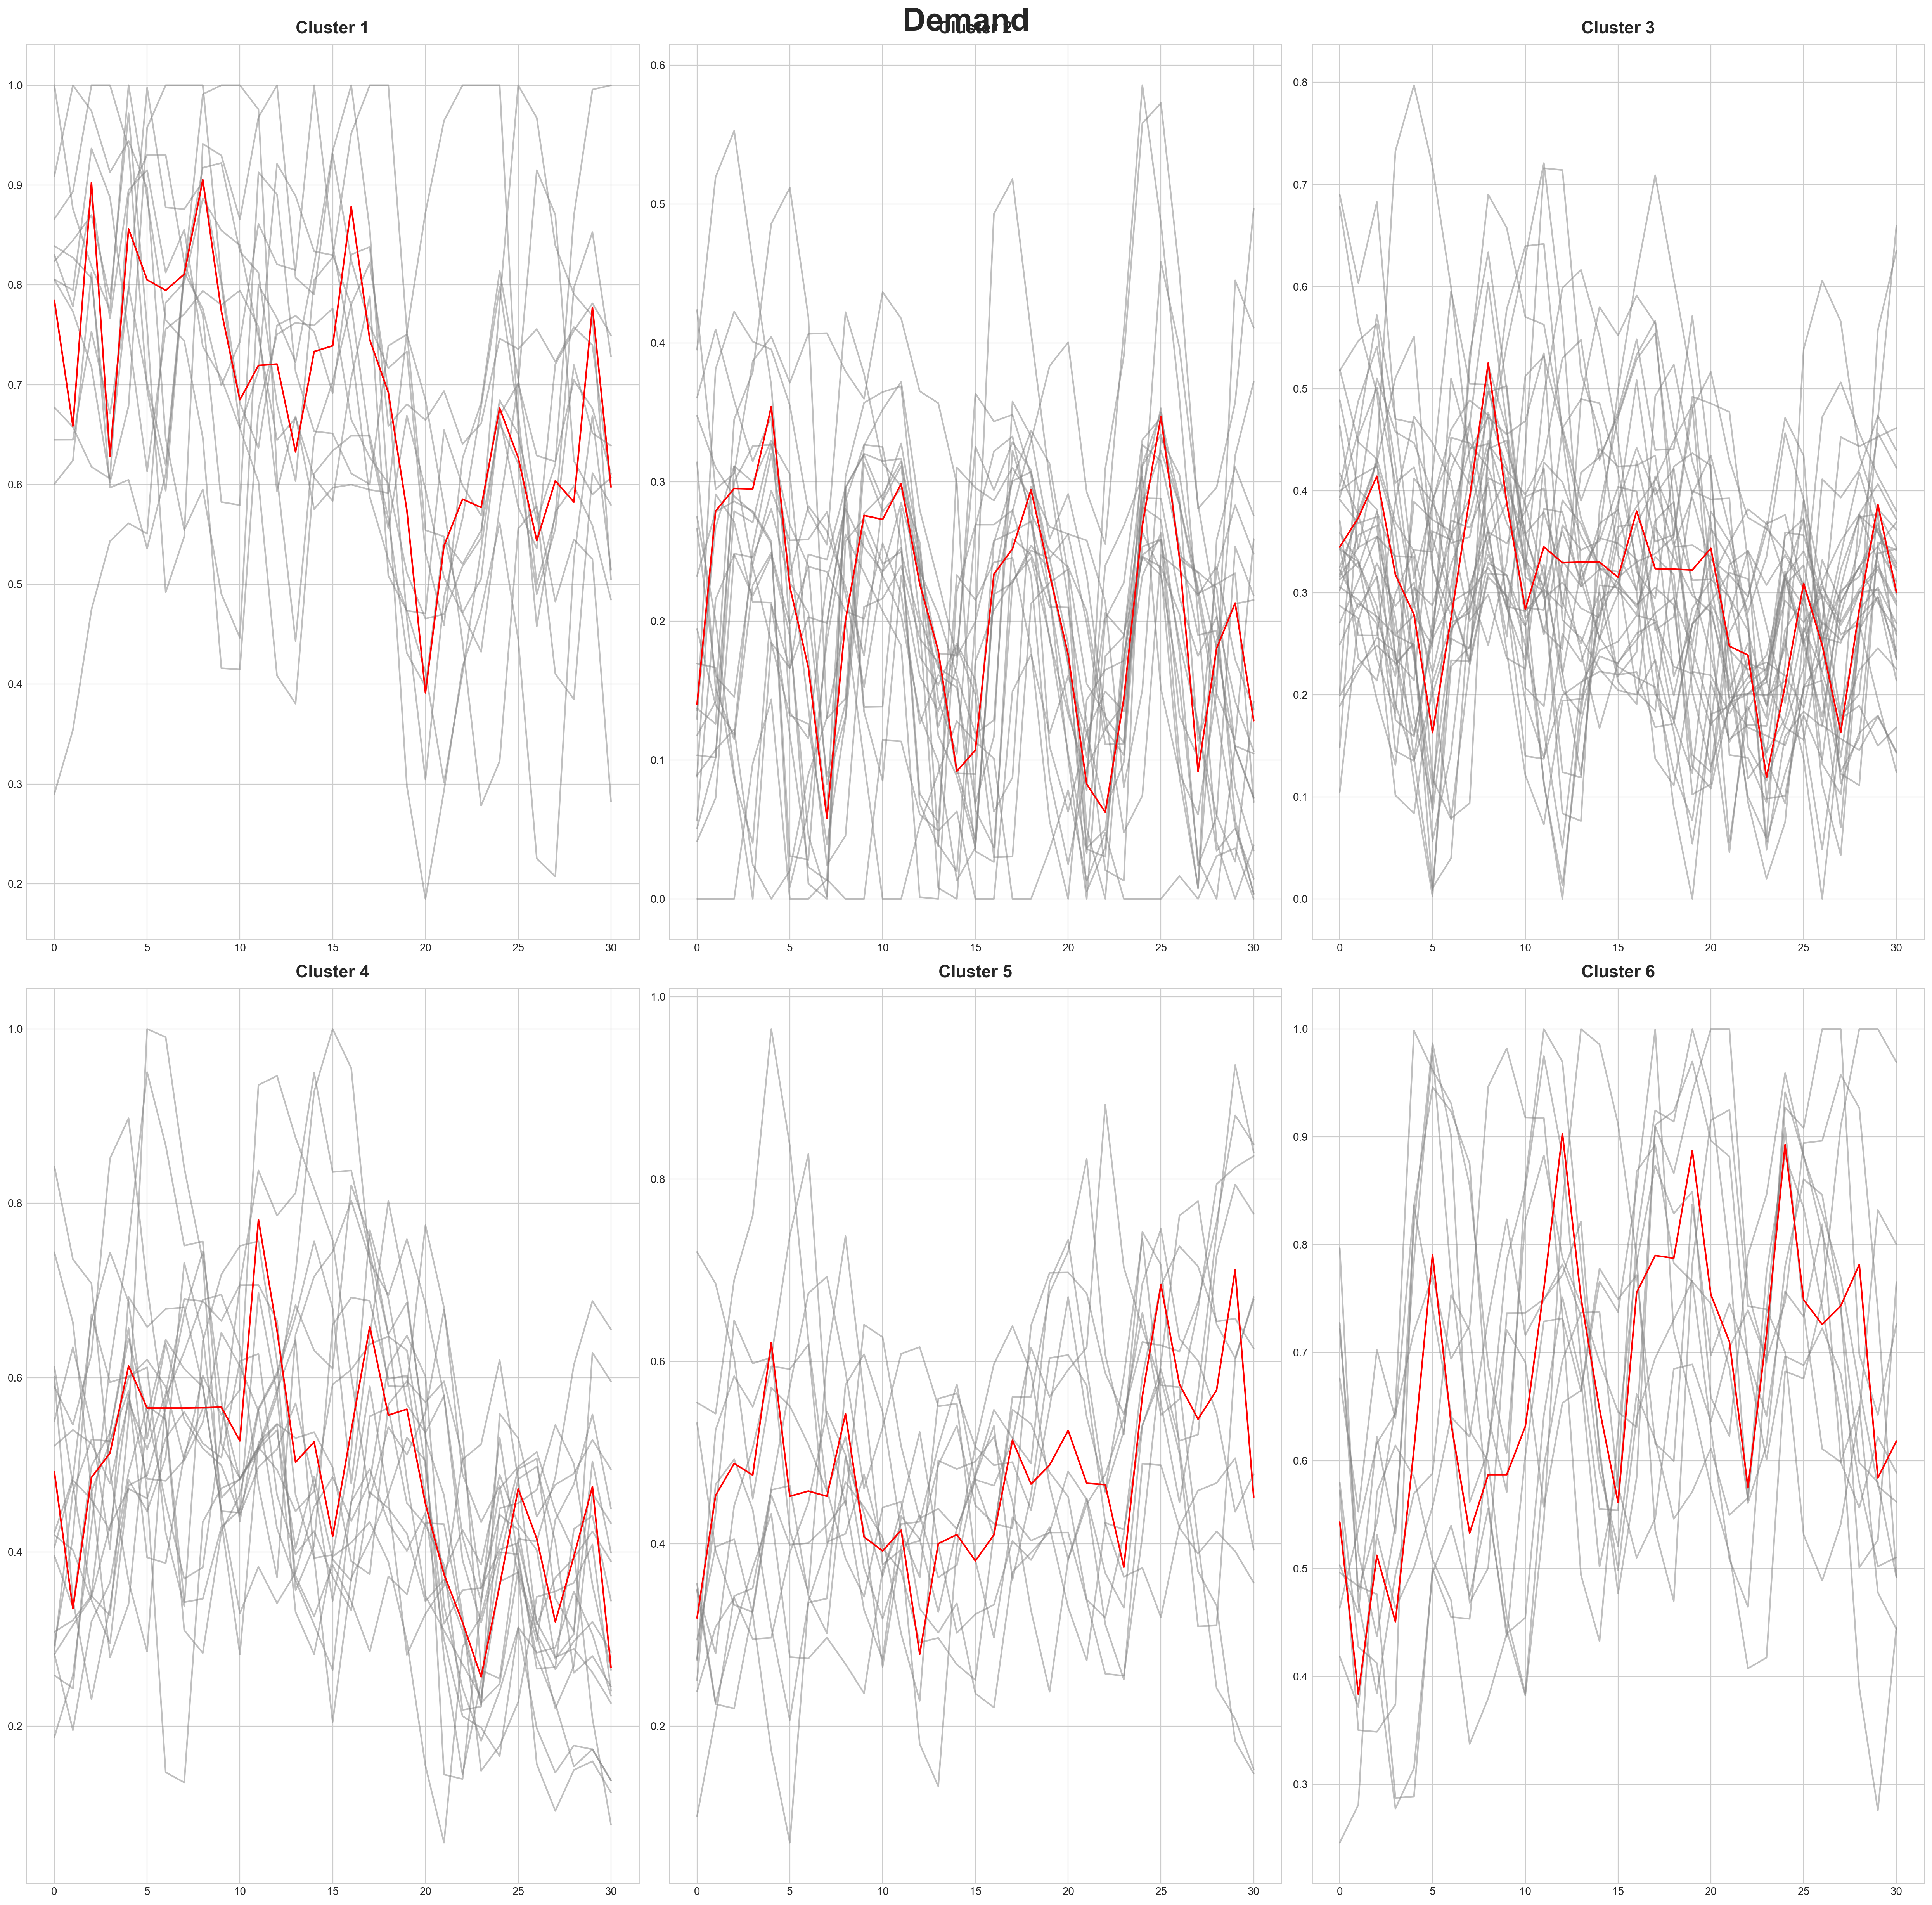

In [239]:
plot_som_series_(2, 3, win_map)


In [240]:
win_map[(2,3)]

[]

In [241]:
pd.set_option('display.max_rows', None)

cluster_map = []
for idx in range(len(m_demand_df)):
    winner_node = som.winner(df_dm[idx])
    cluster_map.append((series_names[idx],f"Cluster {winner_node[0]*4+winner_node[1]+1}"))#the last part of this line is an algorithm to transform the matrix position in an ordered number list

cluster_map_df=pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [242]:
cluster_map_df.head()

Cluster
Series             
2022_aug  Cluster 1
2024_aug  Cluster 1
2023_aug  Cluster 1
2018_jan  Cluster 1
2019_jul  Cluster 1

Meassuring the quality of the clusters

being that the quantization error simply tells you how much information you lose in case that you quantize your data with the SOM (If the quantization error is 0 the weights of your network are exactly as the original data), and this varies with the quantity of som dimension, we are using silhoutte score to meassure how well objects are matched to their own cluster compared to other clusters:

    Cohesion: How similar an object is to its own cluster
    Separation: How similar an object is to other clusters


As silhoutte takes the the data imputed to create the som (this means the np representation of the data after the scales, and lables that should be a 1 dimension dataset with the labels we might use the mapping we did for the clusters map)

In [245]:
score = silhouette_score(df_dm,cluster_map_df['Cluster'],metric='euclidean')

In [246]:
print(score)

-0.06863583799498923
